In [ ]:
!pip install datasets
!pip install --upgrade ragas
!pip install ragas llama_index

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.2/163.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 7.7 MB/s eta 0:00:00
   

In [ ]:
import re
import pandas as pd
import numpy as np
import os
from datasets import Dataset
import logging
import json
import openai

In [ ]:
logging.basicConfig(level=logging.INFO)
from google.colab import userdata

### 1. Testing RAGAS on sample datasets

In [ ]:
from datasets import Dataset
import os
from ragas import evaluate
from ragas.metrics import faithfulness, answer_correctness, answer_similarity, answer_relevancy, context_recall, context_precision


data_samples = {
    'question': ['When was the first super bowl?', 'Who won the most super bowls?'],
    'answer': ['The first superbowl was held on Jan 15, 1967', 'The most super bowls have been won by The New England Patriots'],
    'contexts' : [['The First AFL–NFL World Championship Game was an American football game played on January 15, 1967, at the Los Angeles Memorial Coliseum in Los Angeles,'],
    ['The Green Bay Packers...Green Bay, Wisconsin.','The Packers compete...Football Conference']],
    'ground_truth': ['The first superbowl was held on January 15, 1967', 'The New England Patriots have won the Super Bowl a record six times']
}

dataset = Dataset.from_dict(data_samples)

score = evaluate(dataset,metrics=[faithfulness,answer_correctness, context_recall, context_precision, answer_similarity])
score.to_pandas()

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

,user_input,retrieved_contexts,response,reference,faithfulness,answer_correctness,context_recall,context_precision,semantic_similarity
0,When was the first super bowl?,[The First AFL–NFL World Championship Game was...,"The first superbowl was held on Jan 15, 1967","The first superbowl was held on January 15, 1967",1.0,0.999097,1.0,1.0,0.996387
1,Who won the most super bowls?,"[The Green Bay Packers...Green Bay, Wisconsin....",The most super bowls have been won by The New ...,The New England Patriots have won the Super Bo...,0.0,0.731072,0.0,0.0,0.924290


In [ ]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /content


In [ ]:
path = '/content/drive/MyDrive/inference/cohere/'


### 2.Cohere model results with section header (Pdf plumber )

In [ ]:
import os
import pandas as pd
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness, answer_correctness, answer_similarity,
    context_recall, context_precision, answer_relevancy
)

def clean_contexts(context):
    """Clean and validate context data"""
    if pd.isna(context):
        return [""]  # Return a list with empty string for NaN
    if isinstance(context, str):
        # Remove any weird characters and normalize
        cleaned = context.strip()
        return [cleaned] if cleaned else [""]
    return [""]  # Default case

def process_company_data(csv_path, company_name):
    """Process data for a single company"""
    try:
        # Read the CSV file
        df = pd.read_csv(csv_path)
        print(f"Loaded {len(df)} rows for {company_name}")

        # Clean and prepare the data
        df = df[['question', 'contexts', 'answer', 'ground_truth']].copy()

        # Clean contexts
        df['retrieved_contexts'] = df['contexts'].apply(clean_contexts)

        # Ensure other columns are strings and not null
        df['question'] = df['question'].fillna("")
        df['answer'] = df['answer'].fillna("")
        df['ground_truth'] = df['ground_truth'].fillna("")

        # Convert to Hugging Face dataset
        dataset = Dataset.from_pandas(df)

        # Evaluate metrics
        metrics = [
            faithfulness, answer_correctness, context_recall,
            context_precision, answer_similarity, answer_relevancy
        ]

        score = evaluate(dataset, metrics=metrics)
        score_df = score.to_pandas()

        # Add company name and merge results
        merged_df = pd.concat([df, score_df], axis=1)
        merged_df['company'] = company_name

        return merged_df, len(df), len(score_df)

    except Exception as e:
        print(f"Error processing {company_name}: {str(e)}")
        return None, 0, 0

def main():
    parent_directory = '/content/drive/MyDrive/inference/cohere'
    output_file = "/content/drive/MyDrive/inference/cohere/gemini.csv"
    companies = ["stripe", "revolut", "remitly", "moonpay", "klarna", "gemini", "gdpr", "circle", "bitpay", "bilt"]

    compiled_results = pd.DataFrame()
    total_questions = 0
    total_evaluated_questions = 0

    for company in companies:
        print(f"\nProcessing company: {company}")
        company_path = os.path.join(parent_directory, company)
        csv_file = os.path.join(company_path, f"{company}.csv")

        if os.path.exists(csv_file):
            results, num_questions, num_evaluated = process_company_data(csv_file, company)

            if results is not None:
                compiled_results = pd.concat([compiled_results, results], ignore_index=True)
                total_questions += num_questions
                total_evaluated_questions += num_evaluated
                print(f"Successfully processed {num_evaluated}/{num_questions} questions")
        else:
            print(f"No CSV file found at: {csv_file}")

    # Save results
    if not compiled_results.empty:
        compiled_results.to_csv(output_file, index=False)
        print(f"\nResults saved to: {output_file}")

    # Print summary
    print(f"\nSummary:")
    print(f"Total questions: {total_questions}")
    print(f"Successfully evaluated: {total_evaluated_questions}")

if __name__ == "__main__":
    main()



Processing company: gemini
Loaded 6 rows for gemini


Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Successfully processed 6/6 questions

Results saved to: /content/drive/MyDrive/inference/cohere/gemini.csv

Summary:
Total questions: 6
Successfully evaluated: 6


In [ ]:
import pandas as pd

# File paths for the CSVs
klarna_path = '/content/drive/MyDrive/inference/cohere/gemini.csv'
all_companies_path = '/content/drive/MyDrive/inference/cohere/all_companies_results.csv'

# Read the CSV files
klarna_df = pd.read_csv(klarna_path)
all_companies_df = pd.read_csv(all_companies_path)

# Concatenate the dataframes
concatenated_df = pd.concat([klarna_df, all_companies_df], ignore_index=True)

# Save the concatenated dataframe to a new CSV file
output_path = '/content/drive/MyDrive/inference/cohere/concatenated_results.csv'
concatenated_df.to_csv(output_path, index=False)

output_path


'/content/drive/MyDrive/inference/cohere/concatenated_results.csv'

In [ ]:
weights = {
    'answer_relevancy': 0.45,
    'faithfulness': 0.30,
    'answer_correctness': 0.15,
    'context_precision': 0.04,
    'context_recall': 0.04,
    'semantic_similarity': 0.02
}

def calculate_weighted_avg(row, weights):
    weighted_sum = sum(row[metric] * weight for metric, weight in weights.items())
    return weighted_sum

ragas_df = pd.read_csv("/content/drive/MyDrive/inference/cohere/concatenated_results.csv")

# Calculate weighted average
ragas_df['weighted_average'] = ragas_df.apply(calculate_weighted_avg, axis=1, weights=weights)

# Compute overall weighted average
overall_score = ragas_df['weighted_average'].mean()
print(f"Overall Weighted Average Score: {overall_score}")


Overall Weighted Average Score: 0.6620298723825158


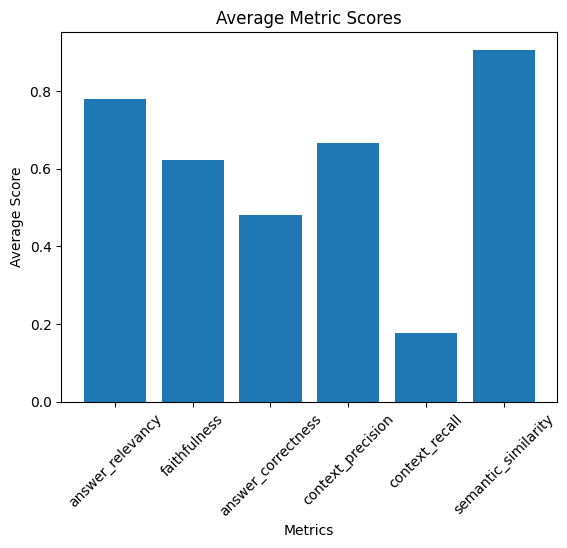

In [ ]:
import matplotlib.pyplot as plt

metric_means = {metric: ragas_df[metric].mean() for metric in weights.keys()}

# Plot
plt.bar(metric_means.keys(), metric_means.values())
plt.title('Average Metric Scores')
plt.ylabel('Average Score')
plt.xlabel('Metrics')
plt.xticks(rotation=45)
plt.show()


In [ ]:
import os
import pandas as pd
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness, answer_correctness, answer_similarity,
    context_recall, context_precision, answer_relevancy
)

def clean_contexts(context):
    """Clean and validate context data"""
    if pd.isna(context):
        return [""]  # Return a list with empty string for NaN
    if isinstance(context, str):
        # Remove any weird characters and normalize
        cleaned = context.strip()
        return [cleaned] if cleaned else [""]
    return [""]  # Default case

def process_company_data(csv_path, company_name):
    """Process data for a single company"""
    try:
        # Read the CSV file
        df = pd.read_csv(csv_path)
        print(f"Loaded {len(df)} rows for {company_name}")

        # Clean and prepare the data
        df = df[['question', 'contexts', 'answer', 'ground_truth']].copy()

        # Clean contexts
        df['retrieved_contexts'] = df['contexts'].apply(clean_contexts)

        # Ensure other columns are strings and not null
        df['question'] = df['question'].fillna("")
        df['answer'] = df['answer'].fillna("")
        df['ground_truth'] = df['ground_truth'].fillna("")

        # Convert to Hugging Face dataset
        dataset = Dataset.from_pandas(df)

        # Evaluate metrics
        metrics = [
            faithfulness, answer_correctness, context_recall,
            context_precision, answer_similarity, answer_relevancy
        ]

        score = evaluate(dataset, metrics=metrics)
        score_df = score.to_pandas()

        # Add company name and merge results
        merged_df = pd.concat([df, score_df], axis=1)
        merged_df['company'] = company_name

        return merged_df, len(df), len(score_df)

    except Exception as e:
        print(f"Error processing {company_name}: {str(e)}")
        return None, 0, 0

def main():
    parent_directory = os.getcwd()
    output_file = "./all_companies_results.csv"
    companies = ["klarna"]  # Add more companies as needed

    compiled_results = pd.DataFrame()
    total_questions = 0
    total_evaluated_questions = 0

    for company in companies:
        print(f"\nProcessing company: {company}")
        company_path = os.path.join(parent_directory, company)
        csv_file = os.path.join(company_path, f"{company}.csv")

        if os.path.exists(csv_file):
            results, num_questions, num_evaluated = process_company_data(csv_file, company)

            if results is not None:
                compiled_results = pd.concat([compiled_results, results], ignore_index=True)
                total_questions += num_questions
                total_evaluated_questions += num_evaluated
                print(f"Successfully processed {num_evaluated}/{num_questions} questions")
        else:
            print(f"No CSV file found at: {csv_file}")

    # Save results
    if not compiled_results.empty:
        compiled_results.to_csv(output_file, index=False)
        print(f"\nResults saved to: {output_file}")

    # Print summary
    print(f"\nSummary:")
    print(f"Total questions: {total_questions}")
    print(f"Successfully evaluated: {total_evaluated_questions}")

if __name__ == "__main__":
    main()


Processing company: klarna
Loaded 5 rows for klarna


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https

Successfully processed 5/5 questions

Results saved to: ./all_companies_results.csv

Summary:
Total questions: 5
Successfully evaluated: 5


In [ ]:
import os
import pandas as pd
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness, answer_correctness, answer_similarity,
    context_recall, context_precision, answer_relevancy
)

# Directory containing company folders
parent_directory = os.getcwd()
output_file = "./all_companies_results.csv"  # Final consolidated file

# Metrics to evaluate
metrics = [
    faithfulness, answer_correctness, context_recall,
    context_precision, answer_similarity, answer_relevancy
]

# Initialize a DataFrame to store all results
compiled_results = pd.DataFrame()

# Initialize counters
total_questions = 0
total_evaluated_questions = 0

# List of companies to process
companies = ["klarna"]  # Add more if needed

# Loop through each company
for company in companies:
    company_path = os.path.join(parent_directory, company)
    print(f"Processing company: {company}")

    if os.path.isdir(company_path):
        csv_file = os.path.join(company_path, f"{company}.csv")

        # Check if the company's CSV file exists
        if os.path.exists(csv_file):
            # Load the company's CSV file
            df = pd.read_csv(csv_file)

            # Count total questions in the company's file
            num_questions = len(df)
            total_questions += num_questions

            # Extract relevant columns (adjust column names as per your dataset)
            df = df[['question', 'contexts', 'answer', 'ground_truth']]

            # Ensure `retrieved_contexts` is in list format
            df['retrieved_contexts'] = df['contexts'].apply(
                lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else [x]
            )

            # Prepare dataset for evaluation
            dataset = Dataset.from_pandas(df)

            # Evaluate metrics
            score = evaluate(dataset, metrics=metrics)
            score_df = score.to_pandas()

            # Count successfully evaluated questions
            num_evaluated_questions = len(score_df)
            total_evaluated_questions += num_evaluated_questions

            # Merge with original data
            merged_df = pd.concat([df, score_df], axis=1)
            merged_df['company'] = company  # Add company name for identification

            # Append to compiled results
            compiled_results = pd.concat([compiled_results, merged_df], ignore_index=True)

            print(f"Processed {num_questions} questions for {company}. Evaluated: {num_evaluated_questions}")
        else:
            print(f"No CSV file found for {company}")
    else:
        print(f"No directory found for {company}")

# Save the compiled results to a single CSV file
compiled_results.to_csv(output_file, index=False)
print(f"All results compiled and saved to: {output_file}")

# Print summary
print(f"Total questions across all companies: {total_questions}")
print(f"Total questions successfully evaluated: {total_evaluated_questions}")


Processing company: klarna


SyntaxError: invalid character '’' (U+2019) (<string>, line 15)

In [ ]:

weights = {
    'answer_relevancy': 0.45,
    'faithfulness': 0.30,
    'answer_correctness': 0.15,
    'context_precision': 0.04,
    'context_recall': 0.04,
    'semantic_similarity': 0.02
}

def calculate_weighted_avg(row, weights):
    weighted_sum = sum(row[metric] * weight for metric, weight in weights.items())
    return weighted_sum

ragas_df = pd.read_csv("all_companies_results.csv")

# Calculate weighted average
ragas_df['weighted_average'] = ragas_df.apply(calculate_weighted_avg, axis=1, weights=weights)

# Compute overall weighted average
overall_score = ragas_df['weighted_average'].mean()
print(f"Overall Weighted Average Score: {overall_score}")


Overall Weighted Average Score: 0.6500319008694851


In [ ]:
# Add hallucination rate calculation to the weights
weights = {
    'answer_relevancy': 0.45,
    'faithfulness': 0.30,
    'answer_correctness': 0.15,
    'context_precision': 0.04,
    'context_recall': 0.04,
    'semantic_similarity': 0.02,
    'hallucination_rate': -0.10   # Negative weight as hallucination impacts negatively
}

def calculate_hallucination_rate(row):
    """
    Calculate hallucination rate based on faithfulness and retrieved contexts.
    If faithfulness is low or retrieved contexts are unrelated, it indicates hallucination.
    """
    return 1 - row['faithfulness']  # Hallucination is inversely proportional to faithfulness

def calculate_weighted_avg(row, weights):
    """
    Calculate the weighted average score including hallucination rate.
    """
    weighted_sum = sum(row[metric] * weight for metric, weight in weights.items())
    return weighted_sum

# Read the CSV file
ragas_df = pd.read_csv("all_companies_results.csv")

# Calculate hallucination rate
ragas_df['hallucination_rate'] = ragas_df.apply(calculate_hallucination_rate, axis=1)

# Calculate weighted average score including hallucination rate
ragas_df['weighted_average'] = ragas_df.apply(calculate_weighted_avg, axis=1, weights=weights)

# Compute overall weighted average score
overall_score = ragas_df['weighted_average'].mean()
print(f"Overall Weighted Average Score (including hallucination rate): {overall_score}")

# Optional: Save the updated DataFrame
ragas_df.to_csv("all_companies_results_with_hallucination.csv", index=False)


Overall Weighted Average Score (including hallucination rate): 0.6074322561731252


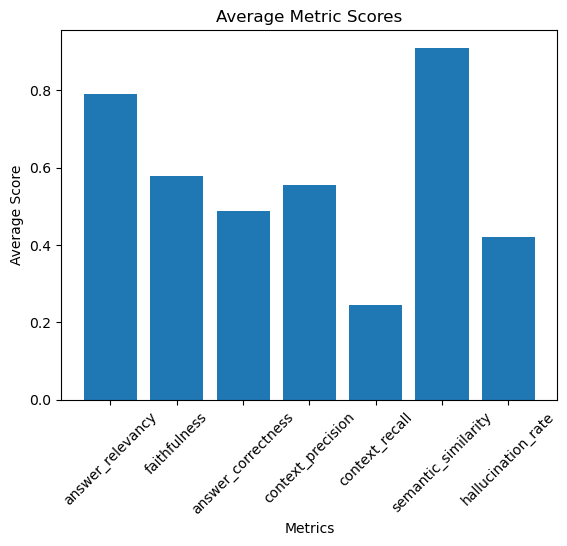

In [ ]:
import matplotlib.pyplot as plt

metric_means = {metric: ragas_df[metric].mean() for metric in weights.keys()}

# Plot
plt.bar(metric_means.keys(), metric_means.values())
plt.title('Average Metric Scores')
plt.ylabel('Average Score')
plt.xlabel('Metrics')
plt.xticks(rotation=45)
plt.show()


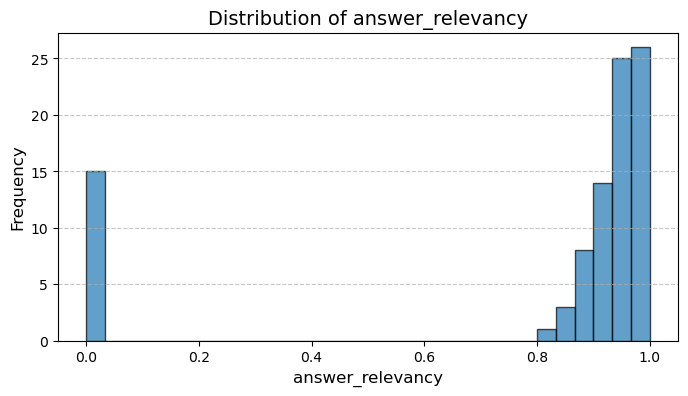

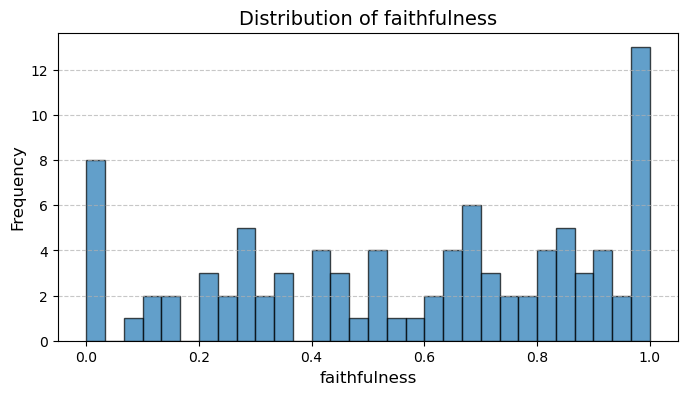

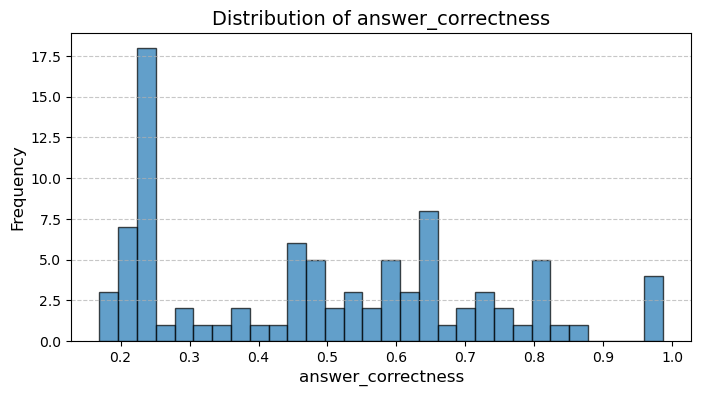

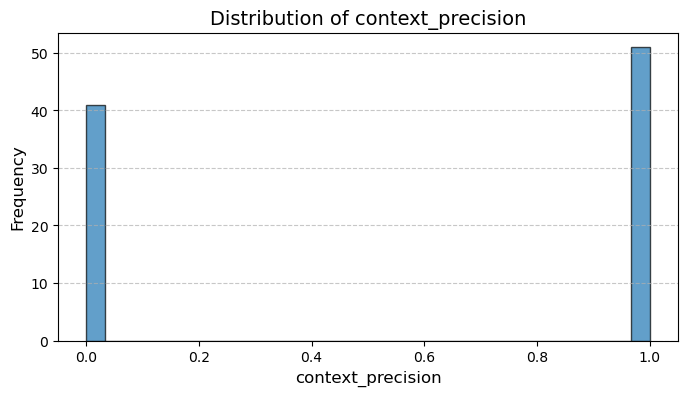

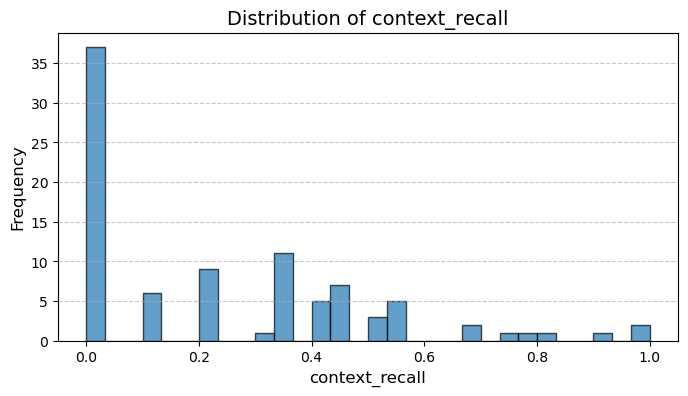

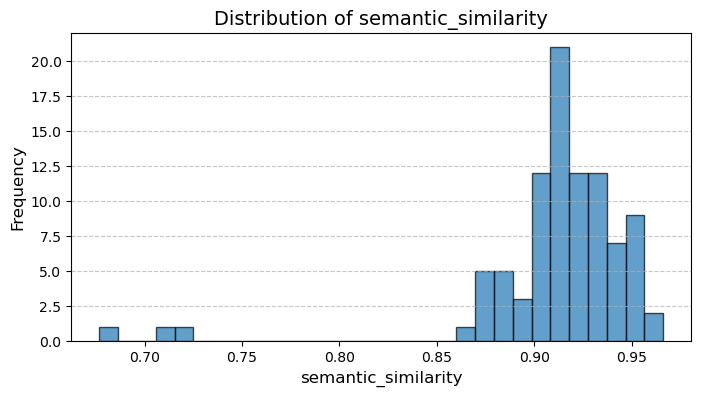

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the RAGAS evaluation results
ragas_df = pd.read_csv("all_companies_results.csv")

# List of metrics to visualize
metrics = [
    'answer_relevancy', 'faithfulness', 'answer_correctness',
    'context_precision', 'context_recall', 'semantic_similarity'
]

# Plot the distribution of each metric
for metric in metrics:
    plt.figure(figsize=(8, 4))
    plt.hist(ragas_df[metric].dropna(), bins=30, edgecolor='k', alpha=0.7)
    plt.title(f"Distribution of {metric}", fontsize=14)
    plt.xlabel(metric, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
